In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision as tv
from PIL import Image
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision.models.detection import fcos
from torchvision.transforms import v2 as v2
from tqdm.auto import tqdm, trange

import bb
import models
import tt

LOG = logging.getLogger(__name__)
tt.logging_init()

SEED = 325
tt.seed(SEED)

In [27]:
data_path = Path.home() / "src/data"
mc_data_path = data_path / "minecraft/info.json"
dset = bb.Dataset.load(mc_data_path)
torch_root = data_path / "torchvision"
ckpt_root = data_path / "checkpoints"

# bb.TorchDataset

In [ ]:
tdset = bb.TorchDataset(data_path / "minecraft")
tdset

In [ ]:
loader = DataLoader(tdset, batch_size=8, collate_fn=bb.TorchDataset.collate_fn)
images, targets = next(iter(loader))
result = tv.utils.make_grid(
    [bb.torch_plot_bb(img, target, tdset.categories) for img, target in zip(images, targets)], nrow=2
)
v2.functional.to_pil_image(result)

In [ ]:
img, target = tdset[10]
categories = tdset.dset.categories
label_names = [categories[label.item()] for label in target["labels"]]
result = bb.torch_plot_bb(img, target, tdset.categories)
v2.functional.to_pil_image(result)

# Minecraft COCO

In [ ]:
# Convert internal format to coco
dset = bb.Dataset.load(mc_data_path)
dset.to_coco(data_path / "coco/minecraft", add_background=True)

In [ ]:
# https://docs.pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html

IMAGES_PATH = data_path / "coco/minecraft/images"
ANNOTATIONS_PATH = data_path / "coco/minecraft/annotations.json"
coco_dataset = tv.datasets.wrap_dataset_for_transforms_v2(
    # The transforms can be v2 since they're handled by the wrapper.
    tv.datasets.CocoDetection(IMAGES_PATH, ANNOTATIONS_PATH, transforms=v2.ToImage())
)

coco_categories = {
    cat["id"]: cat["name"] for cat in coco_dataset.coco.loadCats(coco_dataset.coco.getCatIds())
}
print(coco_categories)

In [ ]:
img, target = coco_dataset[0]
label_names = [coco_categories[label.item()] for label in target["labels"]]
print(target)
print(label_names)
v2.ToPILImage()(img)

# MCDataset

In [ ]:
BATCH_SIZE = 16
TRAIN_PCT = .85

ckpt_file = str(ckpt_root / "checkpoint.pt")
mcd_root = data_path / "coco/minecraft"
mcd = bb.MCDataset(mcd_root)
train_dset, valid_dset = tt.split1(mcd, TRAIN_PCT, SEED)
# bb.plot_bb_grid(images, targets, mcd.categories)

train_loader = DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
    shuffle=True,
    generator=torch.Generator().manual_seed(SEED),
)
valid_loader = DataLoader(
    valid_dset,
    batch_size=BATCH_SIZE,
    collate_fn=bb.MCDataset.collate_fn,
)

print(f"n_train={len(train_dset)}, n_valid={len(valid_dset)}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
n_train=346, n_valid=62


# Fine Tune

In [ ]:
# Test checkpoint
t0 = models.FCOSTrainer(categories=mcd.categories)
t0.save_checkpoint(ckpt_root / "t0.ckpt")
t1 = models.FCOSTrainer(categories=mcd.categories, checkpoint=ckpt_root / "t0.ckpt")
models.compare_models(t0.model, t1.model)

## Compare Inits

In [ ]:
t_normal_init = models.FCOSTrainer(categories=mcd.categories)
t_old_init = models.FCOSTrainer(categories=mcd.categories, old_init=True)

Initializing new model
err_keys = _IncompatibleKeys(missing_keys=['head.classification_head.cls_logits.weight', 'head.classification_head.cls_logits.bias'], unexpected_keys=[])


Initializing new model
err_keys = <All keys matched successfully>


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

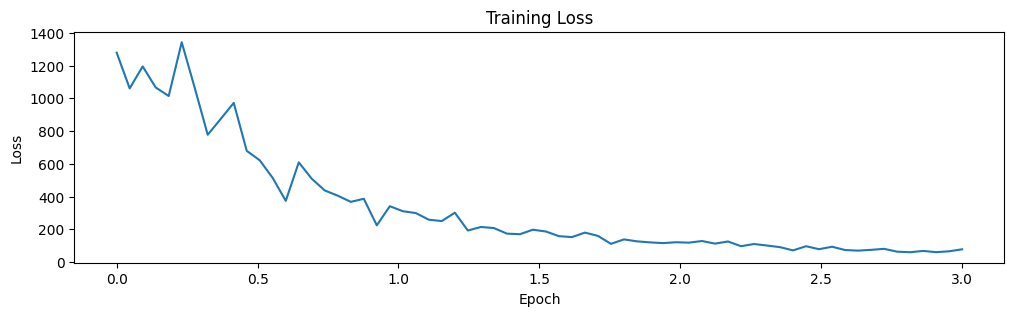

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
t_test = models.FCOSTrainer(categories=mcd.categories, he_init=True)
t_test.train(train_loader=train_loader, num_epochs=8)

Initializing new model
err_keys = <All keys matched successfully>


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

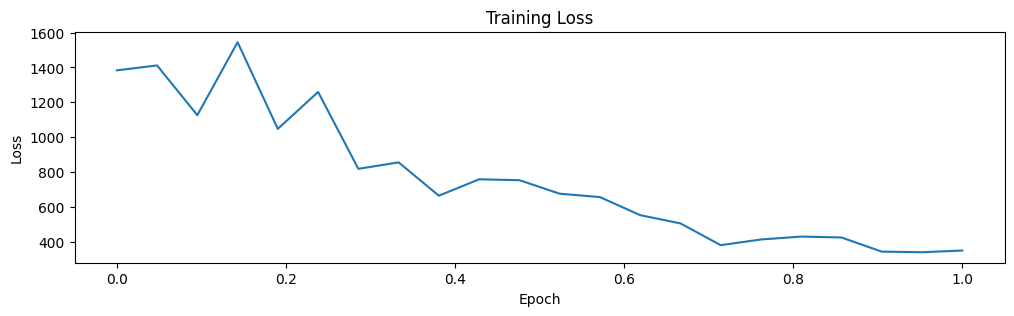

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

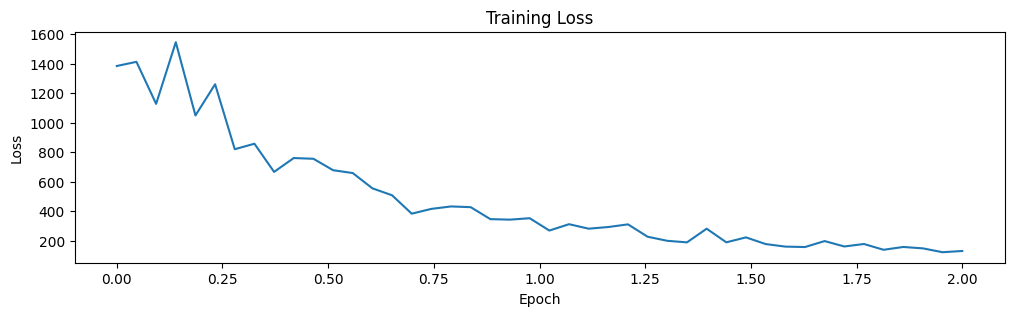

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

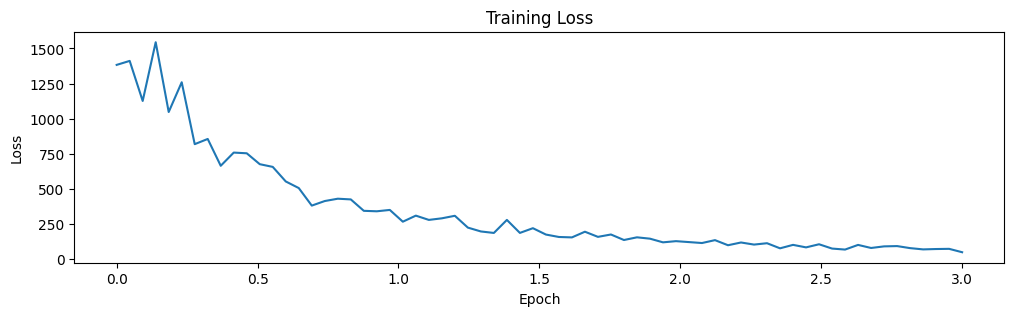

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

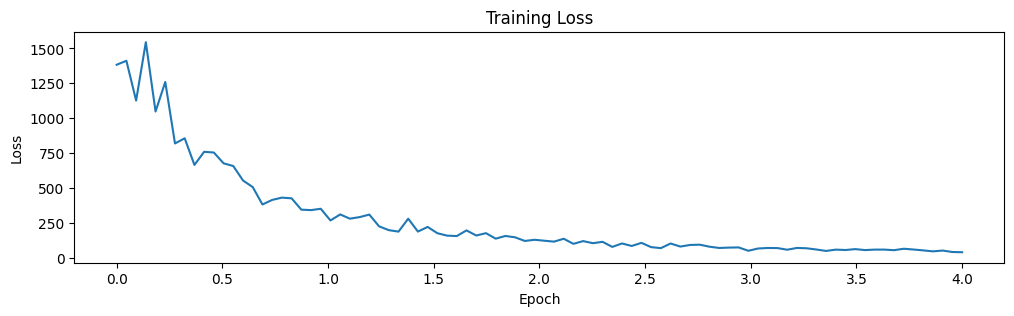

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

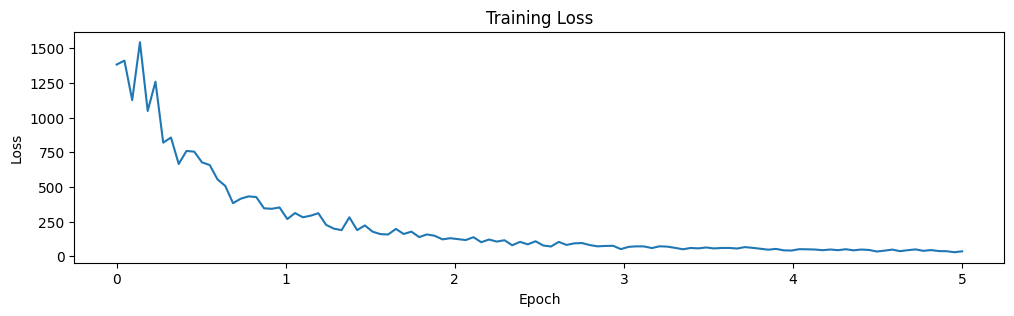

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

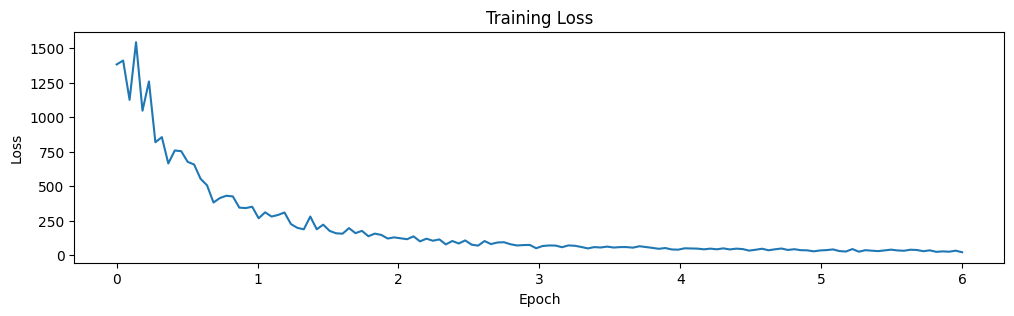

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

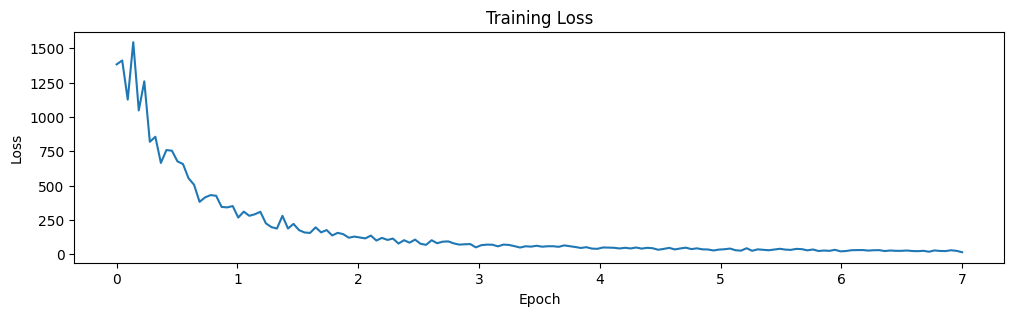

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

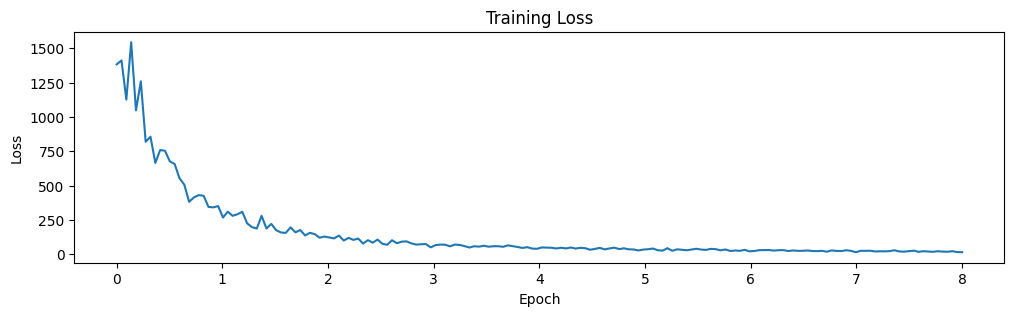

In [ ]:
t_he_init = models.FCOSTrainer(categories=mcd.categories, he_init=True)
t_he_init.train(train_loader=train_loader, num_epochs=8)

Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

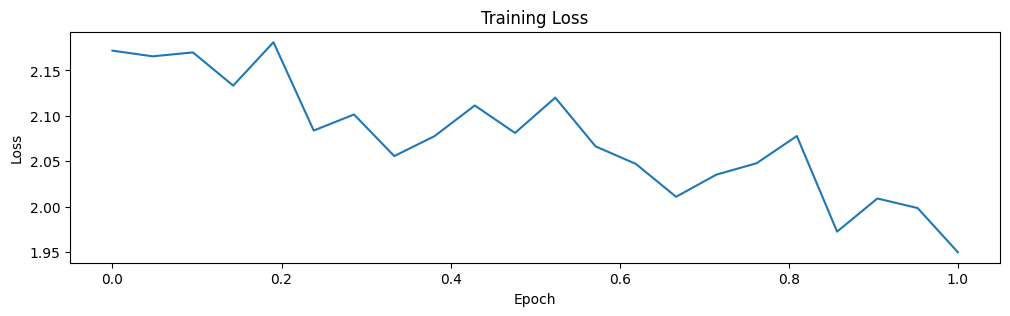

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

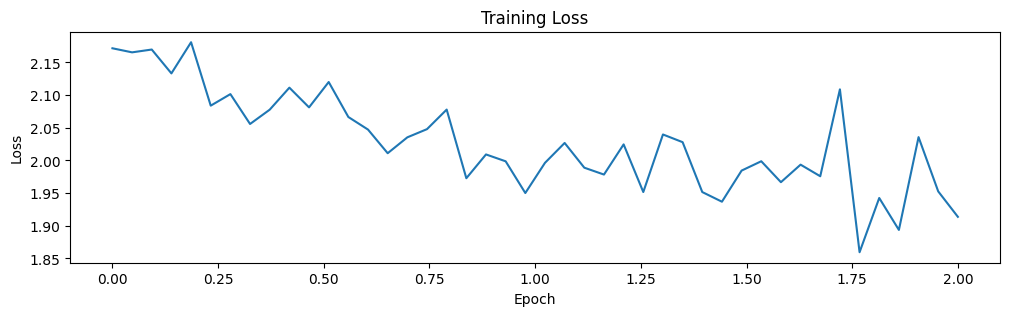

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

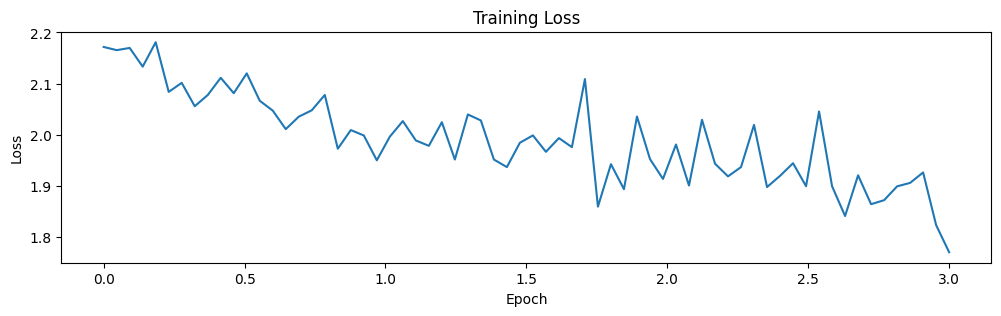

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

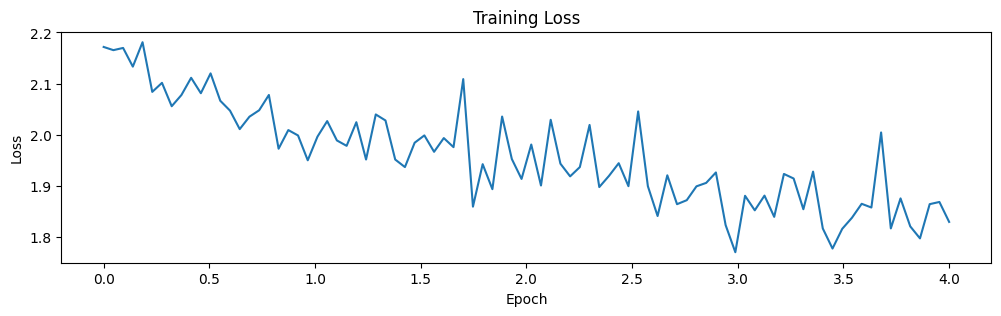

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

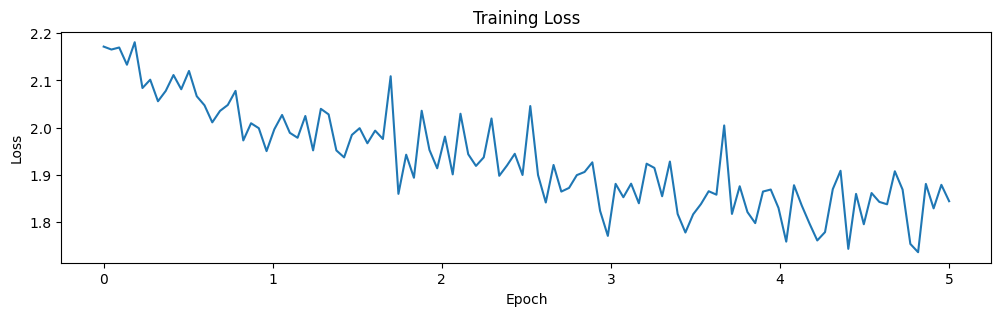

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

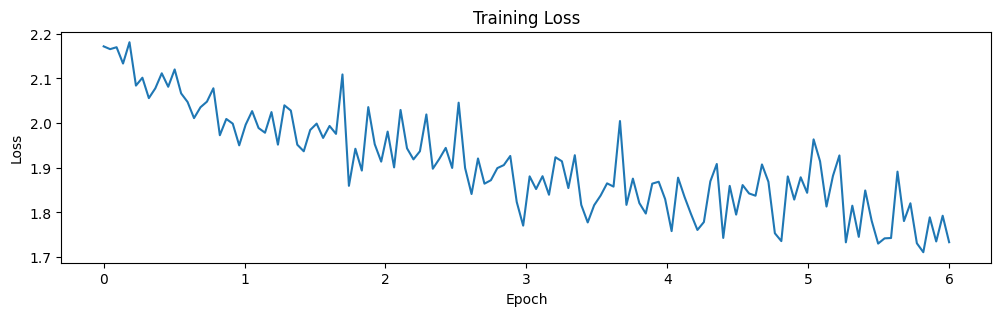

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

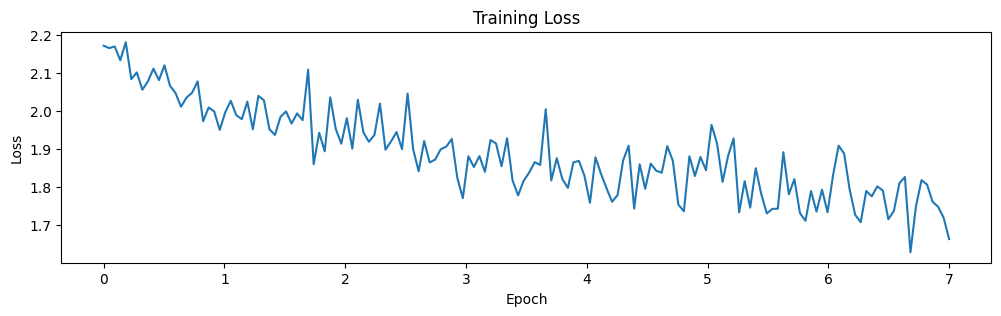

Batch:   0%|          | 0/22 [00:00<?, ?it/s]

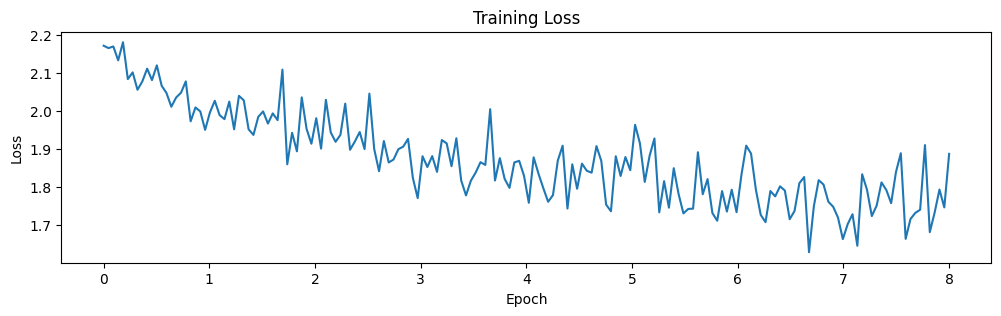

In [ ]:
t_normal_init.train(train_loader=train_loader, num_epochs=8)

In [28]:
t_he_init.save_checkpoint(ckpt_root / "he_init.pt")
t_normal_init.save_checkpoint(ckpt_root / "normal_init.pt")

## Main

In [ ]:


t0 = models.FCOSTrainer(categories=mcd.categories)

m0 = test0()
m1 = t0.model
m0.classification_head.cls_logits

In [ ]:
p0 = dict(m0.head.classification_head.cls_logits.named_parameters())
print(p0["bias"].mean())
print(p0["weight"].mean())

In [ ]:
p1 = dict(m1.head.classification_head.cls_logits.named_parameters())
print(p1["bias"].mean())
print(p1["weight"].mean())

In [ ]:
img_ix = 20
t1.infer(mcd[img_ix][0])

In [ ]:
t1.train_one_epoch(train_loader=train_loader)

In [ ]:
t1.save_checkpoint(ckpt_root / "t1.chkpt")

In [ ]:
t2 = models.FCOSTrainer(categories=mcd.categories, checkpoint=ckpt_root / "t1.chkpt")

In [ ]:
t2.plot_loss()

In [ ]:
img_ix = 20
t1.infer(mcd[img_ix][0])

In [ ]:
# t20 = models.FCOSTrainer(categories=mcd.categories)
t20 = models.FCOSTrainer(categories=mcd.categories, checkpoint=ckpt_root / "t20.ckpt")

In [ ]:
img_ix = 20
pred = t20.infer(mcd[img_ix][0])
pred

labels = [f"{mcd.categories[cat_ix]} {score}"
        for cat_ix, score in zip(pred["labels"], pred["scores"])]
labels

In [ ]:
t20.save_checkpoint(ckpt_root / "t20.ckpt")

In [ ]:
img_ix = 20
t20.plot_infer(mcd[img_ix][0], score_thresh=0.4)

In [ ]:
images, targets = next(iter(train_loader))
bb.plot_bb_grid(images, targets, mcd.categories)

In [ ]:
targets[0]

In [ ]:
train_loader

In [ ]:
t20.train(train_loader=train_loader, num_epochs=20)

In [ ]:
images, targets = next(iter(train_loader))
preds = t20.forward(images, 0.2)
bb.plot_bb_grid(images, preds, mcd.categories, include_scores=True, nrow=2)

In [ ]:
preds2